In [1]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from layers_part_5 import Linear, BatchNorm1d, Tanh, Embedding, FlattenConsecutive, Sequential

In [2]:
# Construct the list of names and produce a dataset
words = list()
with open("names.txt", "r") as infile:
    for line in infile:
        words.append(line.strip())

# Mapping of characters to/from integers
special = "."
chars = sorted(list(set("".join(words))))
STOI = {s: i + 1 for i, s in enumerate(chars)}
STOI[special] = 0
ITOS = {i: s for s, i in STOI.items()}

vocab_size = len(STOI)

In [3]:
random.seed(42)
random.shuffle(words)

In [4]:
block_size = 8

In [5]:
# Construct the dataset


def build_dataset(words, *, special: str = ".", block_size: int = 3) -> "tuple[torch.tensor]":
    (X, Y) = (list(), list())

    for word in words:
        context = [0] * block_size
        for char in word + special:
            ix = STOI[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Constructed dataset: X: {X.shape}, Y: {Y.shape}")
    return X, Y


# Train, Development, Test split
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size=block_size)

Constructed dataset: X: torch.Size([182473, 8]), Y: torch.Size([182473])
Constructed dataset: X: torch.Size([22827, 8]), Y: torch.Size([22827])
Constructed dataset: X: torch.Size([22846, 8]), Y: torch.Size([22846])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(ITOS[ix.item()] for ix in x), "-->", ITOS[y.item()])

........ --> c
.......c --> a
......ca --> t
.....cat --> h
....cath --> y
...cathy --> .
........ --> k
.......k --> e
......ke --> n
.....ken --> a
....kena --> d
...kenad --> i
..kenadi --> .
........ --> a
.......a --> m
......am --> i
.....ami --> .
........ --> l
.......l --> a
......la --> r


In [7]:
torch.manual_seed(42)

In [8]:
# Re-create the training loop with an improved model instantiation

n_embed = 10
n_hidden = 68

model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(2),
        Linear(fan_in=n_embed * 2, fan_out=n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(fan_in=n_hidden * 2, fan_out=n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(fan_in=n_hidden * 2, fan_out=n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(fan_in=n_hidden, fan_out=vocab_size),
    ]
)

with torch.no_grad():
    model.layers[-1].weight *= 0.1  # slightly less confident

parameters = model.parameters
n_parameters = sum(p.nelement() for p in parameters)
print(f"{n_parameters} parameters")
for p in parameters:
    p.requires_grad = True

22397 parameters


In [16]:
model.layers[1].out.shape

torch.Size([1, 4, 20])

In [20]:
model.layers[-5].out.shape

torch.Size([1, 136])

In [9]:
# Optimization loop
max_epoch = 200_000
optimal_rate = 0.1
batch_size = 32
loss_i = list()
update_info = list()

for epoch in range(max_epoch):

    # Construct a mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update step with learning rate decay
    current_rate = 0.0
    if epoch < 0.5 * max_epoch:
        current_rate = optimal_rate
    elif epoch > 0.5 * max_epoch and epoch < 0.75 * max_epoch:
        current_rate = optimal_rate / 10
    elif epoch > 0.75 * max_epoch and epoch < 0.95 * max_epoch:
        current_rate = optimal_rate / 100
    else:
        current_rate = optimal_rate / 1000
    for p in parameters:
        p.data += -current_rate * p.grad

    # Track stats
    if epoch % 10_000 == 0:
        print(f"{epoch:7d}/{max_epoch:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

      0/ 200000: 3.2883
  10000/ 200000: 1.8861
  20000/ 200000: 2.3639
  30000/ 200000: 1.8321
  40000/ 200000: 2.3667
  50000/ 200000: 2.1440
  60000/ 200000: 2.1858
  70000/ 200000: 1.8276
  80000/ 200000: 2.1494
  90000/ 200000: 1.8513
 100000/ 200000: 2.1747
 110000/ 200000: 1.7522
 120000/ 200000: 1.6958
 130000/ 200000: 1.6632
 140000/ 200000: 1.8375
 150000/ 200000: 2.0872
 160000/ 200000: 2.0354
 170000/ 200000: 1.9924
 180000/ 200000: 2.1000
 190000/ 200000: 1.7876


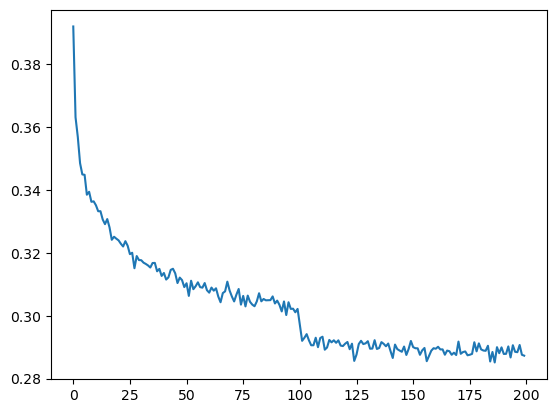

In [10]:
plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

In [11]:
# Put layers in eval mode
for layer in model.layers:
    layer.training = False

In [12]:
# Evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xtest, Ytest),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.925215482711792
val 2.0211985111236572


In [13]:
# Sample from the model
n_samples = 10
with torch.no_grad():
    for _ in range(n_samples):
        out = []
        context = [0] * block_size
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print("".join(ITOS[i] for i in out))

kamontelia.
cori.
chano.
jasla.
anhleigh.
diler.
mattalynn.
halaylah.
hason.
celsa.
